In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm
from scipy.stats import norm

# define the data, 2-D sphere

(-1.5, 1.5)

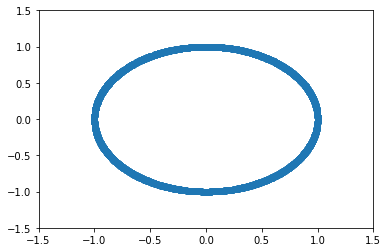

In [2]:
data_dim = 2
train_data = torch.randn(2500,data_dim)
train_data /= torch.norm(train_data,dim=1).reshape(-1,1)
    
plt.scatter(train_data[:,0],train_data[:,1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

# define the time-dependent MLP-UNet

In [3]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# define the denoising loss

In [4]:
def denoising_loss(net, batch_data, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
    predicted_noise = net(noisy_data, noisy_levels)
    loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

# Generation function

In [5]:
def ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()


# training with EMA

In [ ]:
# EPOCH = 1000

# lr=1e-4
# batch_size = 32

# model = UNet_MLP(data_dim, 1, 1).cuda()
# EMA_model = UNet_MLP(data_dim, 1, 1).cuda()
# EMA_model.load_state_dict(deepcopy(model.state_dict()))
# train_data = train_data.cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# progress = tqdm(range(EPOCH))
# for epoch in progress:
#     avg_loss = 0
#     totals = 0
#     for batch_idx in index_iterator(len(train_data), batch_size):
#         optimizer.zero_grad()
#         loss  = denoising_loss(model, train_data[batch_idx])
#         loss.backward()
#         optimizer.step()
#         totals += len(batch_idx)
#         avg_loss += loss.item() * len(batch_idx)
    
#     for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
#         ema_p.data.mul_(0.99).add_(0.01, p.data)

#     progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

#     if (epoch + 1) % 50 == 0:
#         ema_sample_points = ddim_sampling(EMA_model, 1000, eta = 0.3)
#         sample_points = ddim_sampling(model, 1000, eta = 0.3)
#         ema_sample_points_eta0 = ddim_sampling(EMA_model, 1000, eta = 0.)
#         sample_points_eta0 = ddim_sampling(model, 1000, eta = 0.)
#         plt.figure(figsize=(5,5))
#         plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6, label="a")
#         plt.scatter(ema_sample_points[:,0], ema_sample_points[:,1], s=5,alpha=0.6, label="b")
#         plt.scatter(sample_points_eta0[:,0], sample_points_eta0[:,1], s=5,alpha=0.6, label="c")
#         plt.scatter(ema_sample_points_eta0[:,0], ema_sample_points_eta0[:,1], s=5,alpha=0.6, label="d")
#         plt.xlim(-2,2)
#         plt.ylim(-2,2)
#         plt.legend()
#         plt.title("epoch: {}".format(epoch))
#         plt.savefig("temp_results/ddim_{}_mg.png".format(epoch))
#         plt.show()
#         torch.save(model.state_dict(), "temp_results/ddim_mg.pth".format(epoch))
#         torch.save(EMA_model.state_dict(), "temp_results/ddim_ema_mg.pth".format(epoch))
#         print("saved at epoch {}".format(epoch))



# regular sampling

In [6]:
model = UNet_MLP(data_dim, 1, 1).cuda()
model.load_state_dict(torch.load("temp_results/ddim_ema_mg.pth"))

<All keys matched successfully>

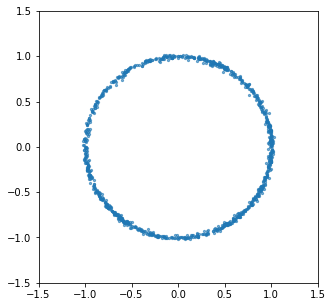

In [7]:
sample_points = ddim_sampling(model, 1000, total_steps=1000, eta = 1)
plt.figure(figsize=(5,5))
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

# sampling with proposed distribution

2.2024049251001543e-14


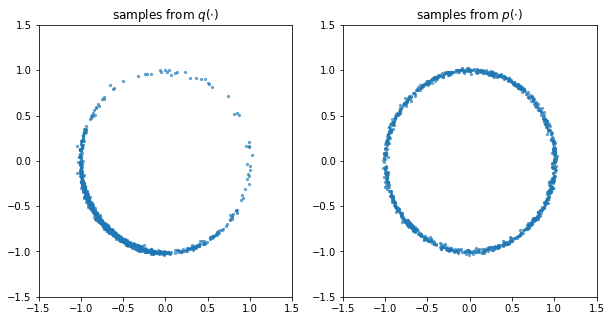

In [8]:
def ddim_proposal_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
            direction += 0.1 + 0.1 * torch.rand_like(direction) # a deterministic bias
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp
    print(now_coeff)

    return sample_points.cpu().numpy()

proposal_sample_points = ddim_proposal_sampling(model, 1000, total_steps=1000, eta = 1)
sample_points = ddim_sampling(model, 1000, total_steps=1000, eta = 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(proposal_sample_points[:,0], proposal_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $q(\cdot)$")
plt.subplot(122)
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $p(\cdot)$")
plt.show()

# sampling with unbiased noise

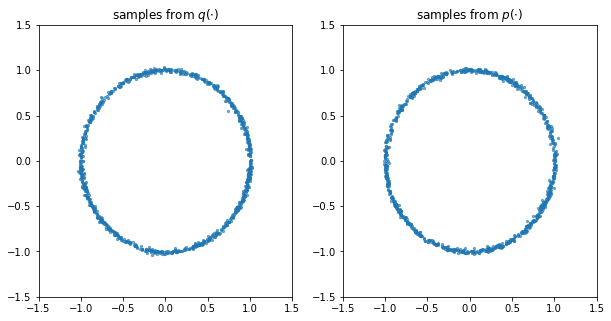

In [9]:
def ddim_unbiased_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for now_step in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
            if now_step in np.arange(0,997):
                direction +=  1 * torch.randn_like(direction) # unbiased
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

proposal_sample_points = ddim_unbiased_sampling(model, 1000, total_steps=1000, eta = 1)
sample_points = ddim_sampling(model, 1000, total_steps=1000, eta = 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(proposal_sample_points[:,0], proposal_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $q(\cdot)$")
plt.subplot(122)
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $p(\cdot)$")
plt.show()

# sampling with quantization bias

In [ ]:
# ToDo

# one step modified rejection sampling

In [10]:
def ddim_os_rejection_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    num_rejected_times = np.zeros(sample_size)
    
    for now_step in range(total_steps):
        nl = eta * np.sqrt(now_coeff - interp) 

        # proceed until all points are accepted
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        biased_direction = direction + 0.1 + 0.1 * torch.rand_like(direction) # a deterministic-random bias
        
        ground_sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction

        
        biased_sample_mean = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * biased_direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * biased_direction

        mean_diff = (ground_sample_mean - biased_sample_mean) / nl

        biased_sample_noise = torch.randn(sample_size,2).cuda()
        likelihood_ratio = torch.exp((torch.norm(biased_sample_noise, dim=1)**2 - torch.norm(biased_sample_noise-mean_diff, dim=1)**2) / 2)
        likelihood_ratio.clamp_(max=1)

        uniform_samples = torch.rand(sample_size).cuda()
        accepted_indices = torch.where(uniform_samples < likelihood_ratio)[0]
        rejected_indices = torch.where(uniform_samples >= likelihood_ratio)[0]

        print("now step:{}, acceptance rate: {}".format(now_step, len(accepted_indices) / sample_size))

        for idx in accepted_indices:
            sample_points[idx] = biased_sample_mean[idx] + nl * biased_sample_noise[idx]

        for idx in rejected_indices:
            # sample from correction distribution
            sample_points[idx] = sample_from_correction_distribution(ground_sample_mean[idx], biased_sample_mean[idx], nl)
            num_rejected_times[idx] += 1

        now_coeff -= interp

    print("Average numbers of rejection", num_rejected_times.mean())
    return sample_points.cpu().numpy()

def sample_from_correction_distribution(mu1, mu2, sigma): # sample from the distribution (N(mu1, nl^2) - N(mu2, nl^2))_+
    mu1 = mu1.cpu().numpy()
    mu2 = mu2.cpu().numpy()
    dim = mu1.shape[-1]
    while True:
        candidates = sigma * np.random.randn(dim) + mu1
        if np.linalg.norm(candidates - mu1) < np.linalg.norm(candidates - mu2):
            test_uniform = np.random.rand()
            likelihood = 1 - np.exp((np.linalg.norm(candidates - mu1)**2 - np.linalg.norm(candidates - mu2)**2)/2/(sigma**2))
            if test_uniform <= likelihood:
                return torch.FloatTensor(candidates).cuda()
    

proposal_sample_points = ddim_os_rejection_sampling(model, 1000, total_steps=1000, eta = 1)
sample_points = ddim_sampling(model, 1000, total_steps=1000, eta = 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(proposal_sample_points[:,0], proposal_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $q(\cdot)$")
plt.subplot(122)
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $p(\cdot)$")
plt.show()

now step:0, acceptance rate: 0.271
now step:1, acceptance rate: 0.889
now step:2, acceptance rate: 0.888
now step:3, acceptance rate: 0.902
now step:4, acceptance rate: 0.9
now step:5, acceptance rate: 0.917
now step:6, acceptance rate: 0.896
now step:7, acceptance rate: 0.9
now step:8, acceptance rate: 0.91
now step:9, acceptance rate: 0.926
now step:10, acceptance rate: 0.907
now step:11, acceptance rate: 0.91
now step:12, acceptance rate: 0.906
now step:13, acceptance rate: 0.924
now step:14, acceptance rate: 0.916
now step:15, acceptance rate: 0.918
now step:16, acceptance rate: 0.911
now step:17, acceptance rate: 0.921
now step:18, acceptance rate: 0.909
now step:19, acceptance rate: 0.918
now step:20, acceptance rate: 0.9
now step:21, acceptance rate: 0.921
now step:22, acceptance rate: 0.916
now step:23, acceptance rate: 0.934
now step:24, acceptance rate: 0.912
now step:25, acceptance rate: 0.914
now step:26, acceptance rate: 0.905
now step:27, acceptance rate: 0.917
now step:2

KeyboardInterrupt: 

# multi steps modified rejection sampling

1000 tensor(1.0000, device='cuda:0') tensor(1.0000, device='cuda:0')
1000 tensor(0.9990, device='cuda:0') tensor(0.9780, device='cuda:0')
1000 tensor(0.9980, device='cuda:0') tensor(0.9560, device='cuda:0')
1000 tensor(0.9970, device='cuda:0') tensor(0.9370, device='cuda:0')
1000 tensor(0.9960, device='cuda:0') tensor(0.9240, device='cuda:0')
1000 tensor(0.9920, device='cuda:0') tensor(0.9030, device='cuda:0')
1000 tensor(0.9870, device='cuda:0') tensor(0.8820, device='cuda:0')
1000 tensor(0.9830, device='cuda:0') tensor(0.8700, device='cuda:0')
1000 tensor(0.9770, device='cuda:0') tensor(0.8610, device='cuda:0')
1000 tensor(0.9720, device='cuda:0') tensor(0.8480, device='cuda:0')
1000 tensor(0.9700, device='cuda:0') tensor(0.8330, device='cuda:0')
1000 tensor(0.9680, device='cuda:0') tensor(0.8230, device='cuda:0')
1000 tensor(0.9660, device='cuda:0') tensor(0.8030, device='cuda:0')
1000 tensor(0.9530, device='cuda:0') tensor(0.7940, device='cuda:0')
1000 tensor(0.9520, device='cuda:0

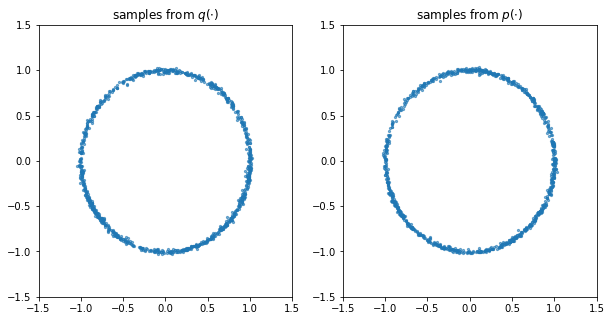

In [20]:
def ddim_ms_rejection_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1., tau = 20):
    interp = (1 - eps) / total_steps

    def _update_with_biased_model(input_points, now_coeff): 
        nl = eta * torch.sqrt(now_coeff - interp)
        nl = nl.view(-1,1) 
        with torch.no_grad():
            direction = model(input_points, now_coeff)
        biased_direction = direction + 0.1 + 0.1 * torch.rand_like(direction)
        now_coeff_expand = now_coeff.view(-1,1)
        coeff2 = now_coeff_expand - interp - nl**2
        coeff2.clamp_(min=0)
        biased_sample_mean = torch.sqrt(1-now_coeff_expand+interp) * (input_points - torch.sqrt(now_coeff_expand) * biased_direction) / torch.sqrt(1-now_coeff_expand) + torch.sqrt(coeff2) * biased_direction

        return biased_sample_mean 
    
    def _sample_from_correction_distribution(mu1, mu2, sigma): # sample from the distribution (N(mu1, nl^2) - N(mu2, nl^2))_+
        dim = mu1.shape[-1]
        while True:
            candidates = sigma * torch.randn(dim).cuda() + mu1
            if torch.norm(candidates - mu1) < torch.norm(candidates - mu2):
                test_uniform = np.random.rand()
                likelihood = 1 - torch.exp((torch.norm(candidates - mu1)**2 - torch.norm(candidates - mu2)**2)/2/(sigma**2))
                if test_uniform <= likelihood.item():
                    return candidates
                
    def _check_and_correction(input_points_hist, input_biased_mean_hist, input_now_coeff_hist):
        # input_points_hist: (sample_size, tau+1, dim), input_points_hist: (sample_size, tau, dim), input_now_coeff_hist: (sample_size, tau + 1)
        # The first thing is to do batch inference
        batch_input_points = torch.cat(input_points_hist)
        batch_now_coeff = torch.cat(input_now_coeff_hist).view(-1,1)
        batch_nl = eta * torch.sqrt(batch_now_coeff - interp) 
        batch_len = [len(p) for p in input_now_coeff_hist]

        batch_direction = torch.zeros_like(batch_input_points)
        infer_indexes = torch.where(batch_now_coeff >= eps)[0]
        with torch.no_grad():
            try:
                batch_direction[infer_indexes] = model(batch_input_points[infer_indexes], batch_now_coeff[infer_indexes].squeeze())
            except:
                pass
        coeff2 = batch_now_coeff - interp - batch_nl**2
        coeff2.clamp_(min=0)
        batch_mean = torch.sqrt(1-batch_now_coeff+interp) * (batch_input_points - torch.sqrt(batch_now_coeff) * batch_direction) / torch.sqrt(1-batch_now_coeff) + torch.sqrt(coeff2) * batch_direction

        batch_len_cumsum = np.cumsum(batch_len)
        batch_mean_output = [batch_mean[(batch_len_cumsum[ind - 1] if ind > 0 else 0) : now_sum] for ind, now_sum in enumerate(batch_len_cumsum)] # should be the same shape with batch_input_points

        output_points = []
        output_now_coeff = []
        for ind, inp_hist in enumerate(input_points_hist):
            biased_output = inp_hist[1:]
            ground_output = batch_mean_output[ind][:-1]
            now_coeff = input_now_coeff_hist[ind][:-1]
            nl = eta * torch.sqrt(now_coeff - interp)
            
            # reject or accept
            biased_likelihood = torch.exp((torch.norm(biased_output-input_biased_mean_hist[ind], dim=1)**2) / 2 / (nl ** 2))
            ground_likelihood = torch.exp((torch.norm(biased_output-ground_output, dim=1)**2) / 2 / (nl ** 2))
            likelihood_ratio = biased_likelihood / ground_likelihood
            likelihood_ratio.clamp_(max=1)
            
            uniform_samples = torch.rand_like(likelihood_ratio).cuda()
            rejected_indices = torch.where(uniform_samples > likelihood_ratio)[0]

            if len(rejected_indices) == 0:
                if input_now_coeff_hist[ind][-1] >= eps:
                    output_nl = eta * torch.sqrt(input_now_coeff_hist[ind][-1] - interp)
                    output_points.append(batch_mean_output[ind][-1] + output_nl * torch.randn_like(batch_mean_output[ind][-1]).cuda())
                    output_now_coeff.append(input_now_coeff_hist[ind][-1] - interp)
                else:
                    output_points.append(input_points_hist[ind][-1].clone())
                    output_now_coeff.append(input_now_coeff_hist[ind][-1].clone())  
            else:
                min_rejected_indices = rejected_indices.min()
                mu1 = ground_output[min_rejected_indices]
                mu2 = input_biased_mean_hist[ind][min_rejected_indices]
                use_coeff = input_now_coeff_hist[ind][min_rejected_indices]
                use_nl = eta * torch.sqrt(use_coeff - interp)
                output_points.append(_sample_from_correction_distribution(mu1, mu2, use_nl))
                output_now_coeff.append(use_coeff - interp)
        

        output_points = torch.stack(output_points)
        output_now_coeff = torch.stack(output_now_coeff)
        return output_points, output_now_coeff

    # generation
    sample_points = torch.randn(sample_size,2).cuda()
    sample_now_coeff = torch.zeros(sample_size).cuda() + 1 - eps
    
    # proceed until all samples are finished
    while torch.any(sample_now_coeff >= eps):
        unfinished_indexes = torch.where(sample_now_coeff >= eps)[0]
        unfinished_sample_points = sample_points[unfinished_indexes].clone()
        unfinished_now_coeff = sample_now_coeff[unfinished_indexes].clone()
        
        print(len(unfinished_indexes), sample_now_coeff.max(), sample_now_coeff.min())

        # running the biased model for (at most) tau steps
        input_points_hist = [[p.clone()] for p in unfinished_sample_points]
        input_biased_mean_hist = [[] for _ in range(len(unfinished_sample_points))]
        input_now_coeff_hist = [[c.clone()] for c in unfinished_now_coeff]

        target_now_coeff = unfinished_now_coeff - interp * tau
        target_now_coeff.clamp_(min=eps)
        while torch.any(unfinished_now_coeff > target_now_coeff):
            inference_indexes = torch.where(unfinished_now_coeff > target_now_coeff)[0]
            inference_sample_points = unfinished_sample_points[inference_indexes]
            inference_now_coeff = unfinished_now_coeff[inference_indexes]
            
            biased_sample_mean = _update_with_biased_model(inference_sample_points, inference_now_coeff)
            now_nl = eta * torch.sqrt(inference_now_coeff - interp)
            now_nl = now_nl.view(-1,1)
            unfinished_sample_points[inference_indexes] = biased_sample_mean + now_nl * torch.randn_like(biased_sample_mean)
            unfinished_now_coeff[inference_indexes] -= interp

            for ind, p in enumerate(unfinished_sample_points[inference_indexes]):
                input_points_hist[inference_indexes[ind]].append(p.clone())
                input_biased_mean_hist[inference_indexes[ind]].append(biased_sample_mean[ind].clone())
                input_now_coeff_hist[inference_indexes[ind]].append(unfinished_now_coeff[inference_indexes][ind].clone())

        # check and correction
        input_points_hist = [torch.stack(p) for p in input_points_hist]
        input_biased_mean_hist = [torch.stack(p) for p in input_biased_mean_hist]
        input_now_coeff_hist = [torch.stack(p) for p in input_now_coeff_hist]

        sample_points[unfinished_indexes], sample_now_coeff[unfinished_indexes] = _check_and_correction(input_points_hist, input_biased_mean_hist,  input_now_coeff_hist)

    return sample_points.cpu().numpy()


proposal_sample_points = ddim_ms_rejection_sampling(model, 1000, total_steps=1000, eta = 1)
sample_points = ddim_sampling(model, 1000, total_steps=1000, eta = 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(proposal_sample_points[:,0], proposal_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $q(\cdot)$")
plt.subplot(122)
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $p(\cdot)$")
plt.show()

2.2024049251001543e-14


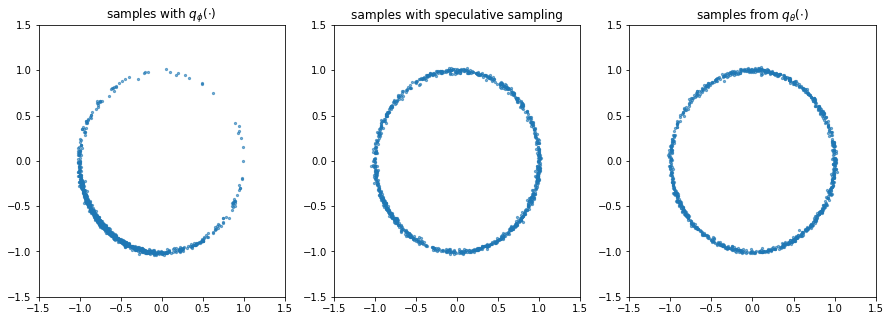

In [26]:
proposal_sample_points1 = ddim_proposal_sampling(model, 1000, total_steps=1000, eta = 1)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(proposal_sample_points1[:,0], proposal_sample_points1[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples with $q_{\phi}(\cdot)$")
plt.subplot(132)
plt.scatter(proposal_sample_points[:,0], proposal_sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples with speculative sampling")
plt.subplot(133)
plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title(r"samples from $q_{\theta}(\cdot)$")
plt.show()

# testing

In [86]:
# d = 10
# nl = 2
# mu1 = np.random.randn(d)
# mu2 = np.random.randn(d)


# # estimate the normalizing constant
# d1 = np.random.randn(1000000,d)
# sample1 = nl * d1 + mu1
# prob1 = np.mean(np.linalg.norm(sample1 - mu1, axis=1) <= np.linalg.norm(sample1 - mu2, axis=1))

# d2 = np.random.randn(1000000,d)
# sample2 = nl * d2 + mu2
# prob2 = np.mean(np.linalg.norm(sample2 - mu1, axis=1) <= np.linalg.norm(sample2 - mu2, axis=1))

# normalizing_constant = prob1 - prob2
# print("normalizing constant 1: {}".format(normalizing_constant))

# # estimate the normalizing constant
# sample1 = d1
# prob1 = np.mean(np.linalg.norm(sample1, axis=1) <= np.linalg.norm(sample1 - (mu1 - mu2) / nl, axis=1))

# sample2 =  d2 + (mu1 - mu2) / nl
# prob2 = np.mean(np.linalg.norm(sample2, axis=1) <= np.linalg.norm(sample2 - (mu1 - mu2) / nl, axis=1))

# normalizing_constant = prob1 - prob2
# print("normalizing constant 2: {}".format(normalizing_constant))

# print("normalizing constant 3: {}".format(2*prob1 - 1))

# print("normalizing constant 4: {}".format(2*norm.cdf(np.linalg.norm(mu1-mu2)/2/nl) -1 ))

normalizing constant 1: 0.7183869999999999
normalizing constant 2: 0.718732
normalizing constant 3: 0.7181360000000001
normalizing constant 4: 0.7181799658747261
